In [2]:
!pip install FlowCal

     |████████████████████████████████| 82 kB 231 kB/s eta 0:00:011
     |████████████████████████████████| 103 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 7.6 MB/s eta 0:00:01
  Created wheel for FlowCal: filename=FlowCal-1.3.0-py3-none-any.whl size=84554 sha256=dee63e7a40708ab4d2ce99cbd9a01cc1a48b782b88d86f553ac717d14fd5fac1
  Stored in directory: /root/.cache/pip/wheels/59/b3/d2/c263ebe3ccd5e34236aeb7b9aa4285ecdb9e91587c9c959e2a
Successfully built FlowCal


In [4]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib 
from matplotlib import pyplot as plt
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import FlowCal
import keras
from keras.utils import Sequence
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, PReLU
from keras.models import Model, Sequential

from keras import backend as K
import tensorflow as tf

In [7]:
data_dir = "../input/samusik-scrna-data/"
s01 = FlowCal.io.FCSData(data_dir + "BM2_cct_normalized_01_non-Neutrophils.fcs")

# Only relevant indexes are 10-47
s01 = s01[:, 10:47]

s01 = np.arcsinh(np.array(s01))
print(s01.shape)


(86864, 37)


In [28]:
"""
Build the simplest possible decoder & encoder
Feed Forward NN with 2 layers

"""
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = '42'

AE2layer = Sequential()
AE2layer.add(Dense(2, input_dim=37, activation="selu", name="encoder"))
AE2layer.add(Dense(37, name="decoder"))
AE2layer.compile(loss="mse", optimizer="adam", metrics=["mse"])

history_2layer = AE2layer.fit(s01, s01, 
                              use_multiprocessing=True,
                              workers=-1,
                              epochs=10)

Epoch 1/10
2715/2715 [==============================] - 3s 1ms/step - loss: 2.3832 - mse: 2.3832
Epoch 2/10
2715/2715 [==============================] - 3s 1ms/step - loss: 1.3223 - mse: 1.3223
Epoch 3/10
2715/2715 [==============================] - 3s 1ms/step - loss: 1.3053 - mse: 1.3053
Epoch 4/10
2715/2715 [==============================] - 3s 1ms/step - loss: 1.2970 - mse: 1.2970
Epoch 5/10
2715/2715 [==============================] - 3s 983us/step - loss: 1.2855 - mse: 1.2855
Epoch 6/10
2715/2715 [==============================] - 3s 994us/step - loss: 1.2803 - mse: 1.2803
Epoch 7/10
2715/2715 [==============================] - 3s 1ms/step - loss: 1.2774 - mse: 1.2774
Epoch 8/10
2715/2715 [==============================] - 3s 1ms/step - loss: 1.2705 - mse: 1.2705
Epoch 9/10
2715/2715 [==============================] - 3s 1ms/step - loss: 1.2697 - mse: 1.2697
Epoch 10/10
2715/2715 [==============================] - 3s 1ms/step - loss: 1.2711 - mse: 1.2711


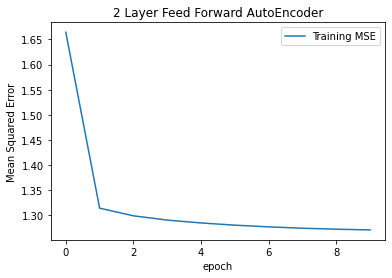

In [29]:
"""
Simplest FF Autoencoder metrics
It seems to overfit, makes sense that it does.
"""

plt.figure(1)
plt.plot(history_2layer.history["loss"])
plt.xlabel("epoch")
plt.ylabel("Mean Squared Error")
plt.legend(["Training MSE", "Validation MSE"])
plt.title("2 Layer Feed Forward AutoEncoder")
plt.savefig("2layerMetrics")


[20.  7.  0. ... 14.  8.  7.]


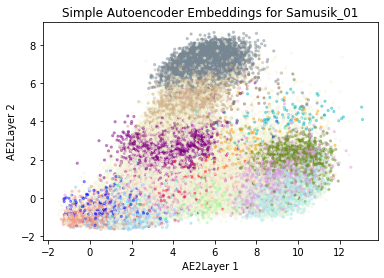

In [30]:
"""
Embeddings generated by simplest FF Model
"""
simple_encoder = AE2layer.get_layer("encoder")
s01_encoding = simple_encoder(s01)

labels = np.array(pd.read_csv(data_dir + "population_assignments01.csv")["Population"])
print(labels)

color_list = ["beige","violet","red","blue","lightsalmon", "cyan","orchid", "plum", 'olivedrab', 'palegreen', 'gold', 'tan', 'slategray','lemonchiffon', "paleturquoise","pink","crimson","orange","mediumvioletred","lightskyblue","navajowhite","sienna","springgreen","c","purple"]
cmap_own = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list)

plt.figure(2)
plt.scatter(s01_encoding[:, 0], s01_encoding[:, 1], c = labels,s=5, alpha=0.4, cmap = cmap_own)
plt.xlabel("AE2Layer 1")
plt.ylabel("AE2Layer 2")
plt.title("Simple Autoencoder Embeddings for Samusik_01")
plt.savefig("2 layer AE embeddings samusik_01")

np.save("s01_2layer", s01_encoding)


In [31]:
"""
Add a few layers to the network, see how it changes embeddings
Still a simple FF model

"""
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = '42'

AE6layer = Sequential()
AE6layer.add(Dense(20, input_dim=37, activation="selu", name="encoder1"))
AE6layer.add(Dense(10, activation="selu", name="encoder2"))
AE6layer.add(Dense(2, activation="selu", name="encoder3"))
AE6layer.add(Dense(10, activation="selu", name="decoder1"))
AE6layer.add(Dense(20, activation="selu", name="decoder2"))
AE6layer.add(Dense(37, name="decoder3"))
AE6layer.compile(loss="mse", optimizer="adam", metrics=["mse"])

"""
history_6layer = AE6layer.fit(x=TrainDG, 
                              use_multiprocessing=True,
                              workers=-1,
                              epochs=20,
                              validation_data=ValidateDG)
"""
history_6layer = AE6layer.fit(s01, s01,
                              use_multiprocessing=True,
                              workers=-1,
                              epochs=20)

Epoch 1/20
2715/2715 [==============================] - 4s 1ms/step - loss: 1.6365 - mse: 1.6365
Epoch 2/20
2715/2715 [==============================] - 4s 1ms/step - loss: 1.0536 - mse: 1.0536
Epoch 3/20
2715/2715 [==============================] - 4s 1ms/step - loss: 1.0132 - mse: 1.0132
Epoch 4/20
2715/2715 [==============================] - 4s 1ms/step - loss: 0.9946 - mse: 0.9946
Epoch 5/20
2715/2715 [==============================] - 4s 1ms/step - loss: 0.9821 - mse: 0.9821
Epoch 6/20
2715/2715 [==============================] - 4s 1ms/step - loss: 0.9725 - mse: 0.9725
Epoch 7/20
2715/2715 [==============================] - 4s 1ms/step - loss: 0.9649 - mse: 0.9649
Epoch 8/20
2715/2715 [==============================] - 4s 1ms/step - loss: 0.9519 - mse: 0.9519
Epoch 9/20
2715/2715 [==============================] - 4s 1ms/step - loss: 0.9372 - mse: 0.9372
Epoch 10/20
2715/2715 [==============================] - 4s 1ms/step - loss: 0.9326 - mse: 0.9326
Epoch 11/20
2715/2715 [======

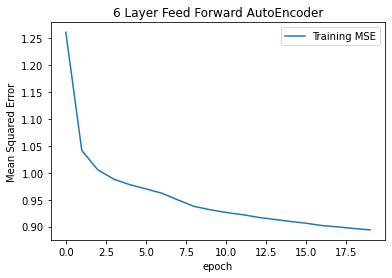

In [32]:
"""
6 layer FF Autoencoder metrics
It also seems to overfit, but it did much better than the 2 layer model.
"""

plt.figure(1)
plt.plot(history_6layer.history["loss"])
plt.xlabel("epoch")
plt.ylabel("Mean Squared Error")
plt.legend(["Training MSE", "Validation MSE"])
plt.title("6 Layer Feed Forward AutoEncoder")
plt.savefig("6layerMetrics")

[20.  7.  0. ... 14.  8.  7.]


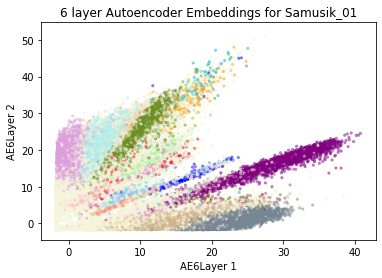

In [33]:
"""
Embeddings generated by 6 layer
"""

e1 = AE6layer.get_layer("encoder1")
e2 = AE6layer.get_layer("encoder2")
e3 = AE6layer.get_layer("encoder3")
s01_encoding = e3(e2(e1(s01)))

labels = np.array(pd.read_csv(data_dir + "population_assignments01.csv")["Population"])
print(labels)

color_list = ["beige","violet","red","blue","lightsalmon", "cyan","orchid", "plum", 'olivedrab', 'palegreen', 'gold', 'tan', 'slategray','lemonchiffon', "paleturquoise","pink","crimson","orange","mediumvioletred","lightskyblue","navajowhite","sienna","springgreen","c","purple"]
cmap_own = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list)

plt.figure()
plt.scatter(s01_encoding[:, 0], s01_encoding[:, 1], c = labels,s=5, alpha=0.4, cmap = cmap_own)
plt.xlabel("AE6Layer 1")
plt.ylabel("AE6Layer 2")
plt.title("6 layer Autoencoder Embeddings for Samusik_01")
plt.savefig("6 layer AE embeddings samusik_01")

np.save("s01_6layer", s01_encoding)

In [34]:
def rec_loss(y_true, y_pred):
    """ Reconstruction error """

    return K.sum(K.square(y_true - y_pred))


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = '42'    

stdev = 1
    
x = Input(shape=(37,), name="input")
E1 = Dense(20, activation="selu", name="E1")(x)
E2 = Dense(10, activation="selu", name="E2")(E1)
mu = Dense(2, name="mu")(E2)
log_var = Dense(2, name="log_var")(E2)

KL = KLDivergenceLayer(name="KL")([mu, log_var])
sigma = Lambda(lambda t: K.exp(.5*t), name="sigma")(log_var)

z_eps = Multiply(name="z_eps")([sigma, K.random_normal(stddev=stdev,shape=(K.shape(x)[0], 2))])
z = Add(name="z")([mu, z_eps]) # not zeps

D1 = Dense(10, activation="selu", name="D1")(z)
D2 = Dense(20, activation="selu", name="D2")(D1)
D3 = Dense(37, name="D3")(D2)

VAE = Model(inputs=x, outputs=D3)
VAE.compile(loss=rec_loss, optimizer="adam", metrics=["mse"])

VAE_history = VAE.fit(s01, s01,
                      use_multiprocessing=True,
                      workers=-1,
                      epochs=20,
                      shuffle=True)

Epoch 1/20
2715/2715 [==============================] - 4s 1ms/step - loss: 1969.2742 - mse: 1.6632
Epoch 2/20
2715/2715 [==============================] - 4s 1ms/step - loss: 1191.5845 - mse: 1.0064
Epoch 3/20
2715/2715 [==============================] - 4s 1ms/step - loss: 1161.7049 - mse: 0.9812
Epoch 4/20
2715/2715 [==============================] - 4s 1ms/step - loss: 1143.5366 - mse: 0.9658
Epoch 5/20
2715/2715 [==============================] - 4s 1ms/step - loss: 1128.4132 - mse: 0.9531
Epoch 6/20
2715/2715 [==============================] - 4s 1ms/step - loss: 1113.4157 - mse: 0.9404
Epoch 7/20
2715/2715 [==============================] - 4s 1ms/step - loss: 1103.6821 - mse: 0.9322
Epoch 8/20
2715/2715 [==============================] - 4s 1ms/step - loss: 1093.4779 - mse: 0.9235
Epoch 9/20
2715/2715 [==============================] - 4s 1ms/step - loss: 1084.5457 - mse: 0.9160
Epoch 10/20
2715/2715 [==============================] - 4s 1ms/step - loss: 1080.6209 - mse: 0.9127

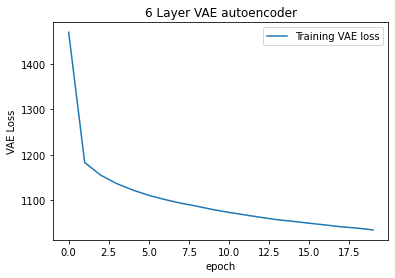

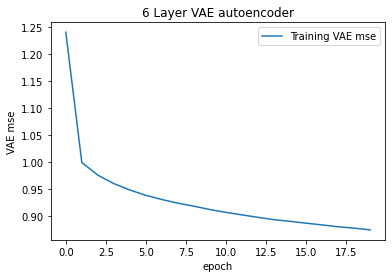

In [35]:
"""
6 layer VAE Autoencoder metrics
"""

plt.figure(1)
plt.plot(VAE_history.history["loss"])
plt.xlabel("epoch")
plt.ylabel("VAE Loss")
plt.legend(["Training VAE loss", "Validation VAE loss"])
plt.title("6 Layer VAE autoencoder")
plt.savefig("VAELoss")

plt.figure(2)
plt.plot(VAE_history.history["mse"])
plt.xlabel("epoch")
plt.ylabel("VAE mse")
plt.legend(["Training VAE mse", "Validation VAE mse"])
plt.title("6 Layer VAE autoencoder")
plt.savefig("VAEMSE")


#VAE.evaluate(x=TestDG, use_multiprocessing=True, workers=-1)

[20.  7.  0. ... 14.  8.  7.]


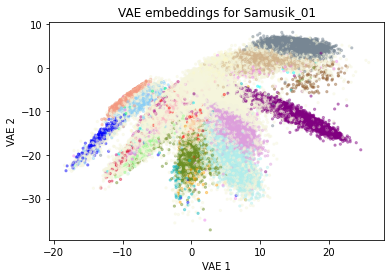

In [36]:
"""
Embeddings generated by VAE 6 layer
"""
e1 = VAE.get_layer("E1")
e2 = VAE.get_layer("E2")
e3 = VAE.get_layer("mu")
s01_mu = e3(e2(e1(s01)))

labels = np.array(pd.read_csv(data_dir + "population_assignments01.csv")["Population"])
print(labels)

color_list = ["beige","violet","red","blue","lightsalmon", "cyan","orchid", "plum", 'olivedrab', 'palegreen', 'gold', 'tan', 'slategray','lemonchiffon', "paleturquoise","pink","crimson","orange","mediumvioletred","lightskyblue","navajowhite","sienna","springgreen","c","purple"]
cmap_own = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list)

plt.figure()
plt.scatter(s01_mu[:, 0], s01_mu[:, 1], c = labels,s=5, alpha=0.4, cmap = cmap_own)
plt.xlabel("VAE 1")
plt.ylabel("VAE 2")
plt.title("VAE embeddings for Samusik_01")
plt.savefig("VAE embeddings samusik_01")

np.save("s01_vae", s01_mu)